In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pyswarm


In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pyswarm import pso

In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Data/data.csv')
df = pd.DataFrame(data)

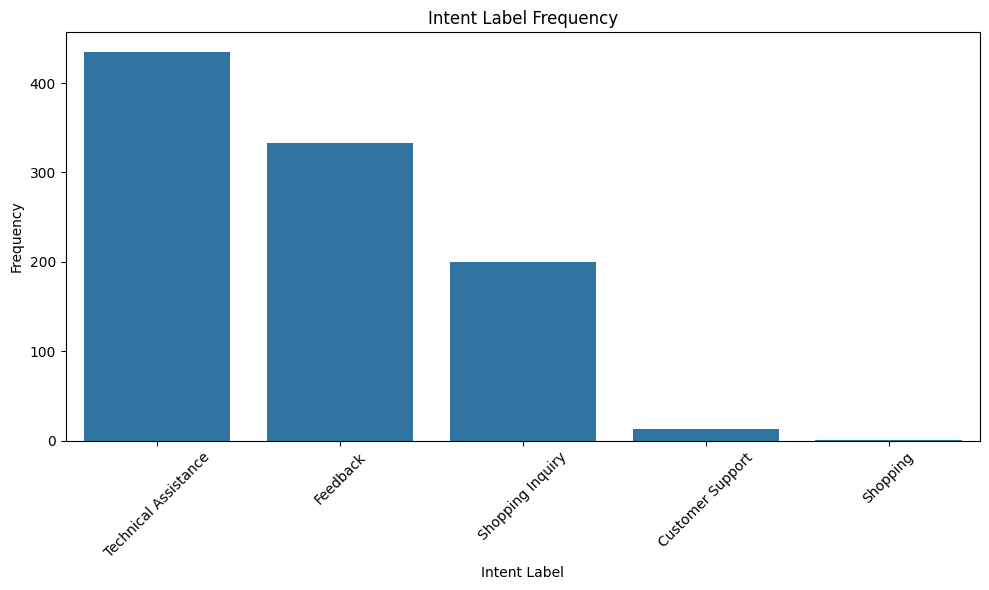

In [10]:
# Count the frequency of each intent
intent_counts = data['intent'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=intent_counts.index, y=intent_counts.values)
plt.title('Intent Label Frequency')
plt.xlabel('Intent Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text']).toarray()
y = df['intent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Particle Swarm Optimization (PSO) for feature selection
class PSOAlgorithm:
    def __init__(self, num_features, num_particles=50, max_iter=20):
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.num_features = num_features

    def fitness(self, x, X_train, y_train):
        features_selected = X_train[:, x.astype(bool)]
        clf = MultinomialNB()
        clf.fit(features_selected, y_train)
        accuracy = clf.score(features_selected, y_train)
        return -accuracy  # Minimize negative accuracy

    def fit(self, X_train, y_train):
        lb = np.zeros(self.num_features)
        ub = np.ones(self.num_features)
        xopt, _ = pso(self.fitness, lb, ub, args=(X_train, y_train), swarmsize=self.num_particles, maxiter=self.max_iter)
        self.best_features = xopt.astype(bool)

    def transform(self, X):
        return X[:, self.best_features]

# Fit PSO algorithm to select features
pso_algo = PSOAlgorithm(num_features=X_train.shape[1])
pso_algo.fit(X_train, y_train)

# Transform training and testing data with selected features
X_train_selected = pso_algo.transform(X_train)
X_test_selected = pso_algo.transform(X_test)

# Train classifier
clf = MultinomialNB()
clf.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Stopping search: maximum iterations reached --> 20
Accuracy: 0.9187817258883249


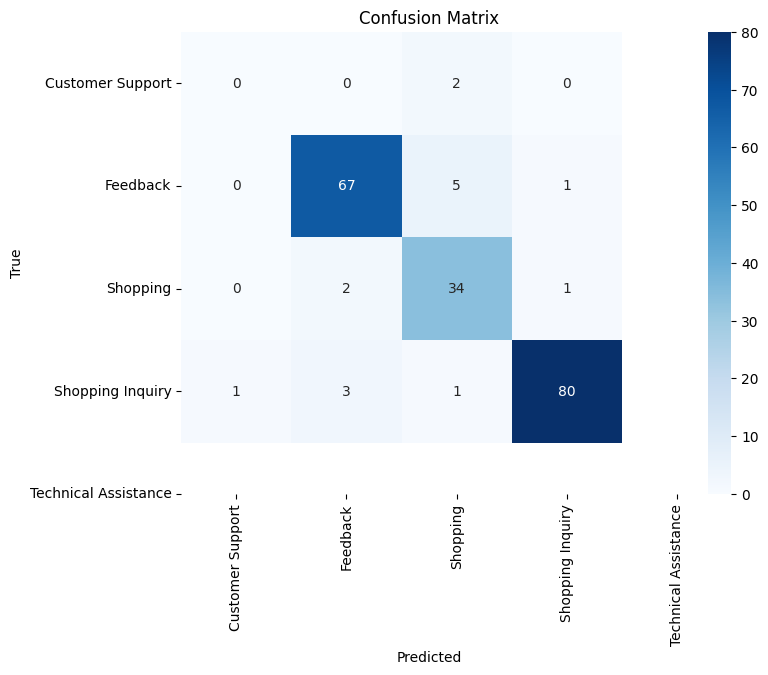

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [14]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                      precision    recall  f1-score   support

    Customer Support       0.00      0.00      0.00         2
            Feedback       0.93      0.92      0.92        73
    Shopping Inquiry       0.81      0.92      0.86        37
Technical Assistance       0.98      0.94      0.96        85

            accuracy                           0.92       197
           macro avg       0.68      0.69      0.69       197
        weighted avg       0.92      0.92      0.92       197



In [16]:
# User input for custom text
custom_text = input("Enter your text: ")
custom_text_vectorized = vectorizer.transform([custom_text]).toarray()
custom_text_selected = pso_algo.transform(custom_text_vectorized)
predicted_intent = clf.predict(custom_text_selected)[0]
print("Predicted intent:", predicted_intent)


Enter your text: Yeh product ka delivery time kitna hai?
Predicted intent: Shopping Inquiry
